# Approximating Autoregressive Processes
### by [Jason DeBacker](http://jasondebacker.com), July 2017
This Jupyter notebook was written using Python 3.6. To execute all the code here, one will need a the Python script `ar1_approx.py` to be located in a directory with the relative path `..\Code\`.

Consider the AR(1) process given by:

$$ ln(z_{t+1}) = \rho ln(z_{t}) + (1-\rho)\mu + \varepsilon_{t}, $$

where $\varepsilon_{t}\sim N(0,\sigma_{\varepsilon})$.  

With such a process, $z$ can take on any value on the real line.  The distribution of $z$ looks like:

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


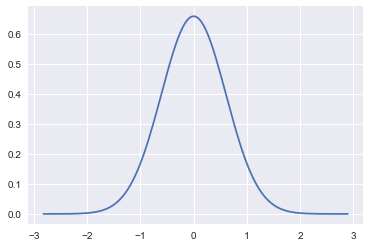

In [3]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# to print plots inline
%matplotlib inline

# set out parameters
rho = 0.8
mu = 0.0
sigma_eps = 0.2

# draw our shocks
num_draws = 100000 # number of shocks to draw
eps = np.random.normal(0.0, sigma_eps, size=(num_draws))

# Compute z
z = np.empty(num_draws)
z[0] = 0.0 + eps[0]
for i in range(1, num_draws):
    z[i] = rho * z[i - 1] + (1 - rho) * mu + eps[i]
    

# plot distribution of z
# sns.distplot(z, hist=False)
sns.kdeplot(np.array(z), bw=0.5)

The distribution of $z$ should have variance = $\sigma_{z}^{2} = \frac{\sigma_{\epsilon}^{2}}{(1-\rho)}$.  Let's check: 

In [4]:
# theory says:
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
print('Theoretical sigma_z = ', sigma_z)

# from our simulation:
sigma_z_simul = z.std()
print('Simulated sigma_z = ', sigma_z_simul)

Theoretical sigma_z =  0.3333333333333334
Simulated sigma_z =  0.33425098989


Pretty close.  And it will get closer as you increae `N`.  

For the computational solution to our dynamic programming problem, we'll want to approximate this continuous distribution with something over a finite grid.  There are a number of methods to do this (see Adda and Cooper (2003, pp. 56-59), Tauchen and Hussey (1991), and Rouwenhorst (1995) for some approaches).  What all of these approaches have in common is that they approximate the autoregressive process with a Markov process (technically a Markov chain, since it's over a finite grid). Generally, the approach is to divide the real line over which $z$ is defined into a finite set of intervals.  These approaches then compute the probabilities of transitioning between one interval and another to match the autoregressive processs.

## 1. Adda-Cooper (2003) method

Let us illustrate the general approach of these approximation methods through the Adda and Cooper (2003, pp. 56-59) (henceforth AC) method.  

AC start by dividing the real line into intervals.  In particular, they divide the real line into intervals such that $z_{t}$ has an equal probability of falling into any of the intervals.  Since $\varepsilon$ is distributed normally, the cut-off points given by $\left\{z^{i}\right\}_{i=0}^{N}$ for these intervals are defined by:

$$ \Phi\left(\frac{z^{i+1}-\mu}{\sigma_{z}}\right) - \Phi\left(\frac{z^{i}-\mu}{\sigma_{z}}\right) = \frac{1}{N}, $$

where $N$ are the number of grid points in our discretized grid space and $\Phi(\cdot)$ is the cumulative density function of the standard normal distribution.  Solving this recursively we find that each cut-off point is given by:

$$ z^{i} = \sigma_{z} \Phi^{-1}\left(\frac{i-1}{N}\right) + \mu $$ 

In [5]:
# import packages
from scipy.stats import norm

# Compute cut-off values
N = 5  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)

Cut-off values =  [       -inf -0.28054041 -0.08444903  0.08444903  0.28054041         inf]


Now that we've defined the intervals through these cut-off values, we'll next want to compute the average value of $z$ in each of these intervals.  These values will be our grid points.  Let $z_{p}^{i}$ be grid point $i$ and define $z_{p}^{i}$ as the mean value of $z_{t}$ conditional on $z_{t}\in\left[z^{i},z^{i+1}\right]$.  That is:

$$ z_{p}^{i} = E\left(z_{t}|z_{t}\in \left[z^{i},z^{i+1}\right] \right) = \sigma_{z} \frac{\phi((z^{i}-\mu)/\sigma_z) - \phi((z^{i+1}-\mu)/\sigma_z)}{\Phi((z^{i+1}-\mu)/\sigma_z) - \Phi((z^{i}-\mu)/\sigma_z)} + \mu $$

Simplifying:

$$ z_{p}^{i} = N \sigma_z \left(\phi\left(\frac{z^{i}-\mu}{\sigma_z}\right) - \phi\left(\frac{z^{i+1}-\mu}{\sigma_z}\right) \right) + \mu $$

In [6]:
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)

Grid points =  [-0.4666032  -0.17730102  0.          0.17730102  0.4666032 ]


Now we have our grid points.  Next, we need to determine the transitions between these grid points.  We want these transition probabilities to be such they they match the autocorrelation in the AR(1) process we are modeling using a first over Markov process.

Define the probability of transitioning between grid point i and grid point j as: 

$$ \pi_{i,j} = P\left( z_{t} \in \left[z^{j},z^{j+1} \right] | z_{t-1} \in \left[z^{i},z^{i+1} \right] \right) $$

Using the fact that $\varepsilon \sim N(0,\sigma_{\varepsilon})$, we have:

$$ \pi_{i,j} = \frac{N}{\sqrt{2\pi\sigma_{z}^{2}}} \int_{z^{i}}^{z^{i+1}} e^{-(\varepsilon - \mu)^{2}/(2\sigma_{z}^{2})} \left[ \Phi\left(\frac{z^{j+1} - \mu(1-\rho) - \rho\mu}{\sigma_{\varepsilon}}\right) - \Phi\left(\frac{z^{j} - \mu(1-\rho) - \rho\mu}{\sigma_{\varepsilon}}\right) \right] d\varepsilon $$

To find each $\pi_{i,j}$, we ned to evaluate this integral.  We'll do so numerically.

In [7]:
# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
# print('Transition matrix = ', pi)
# print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))

We've now found 

$$ \pi_{i,j} = P(z_{t}=z_{p}^{j}|z_{t-1}=z_{p}^{i}) $$

Let's see how well this Markov process approximates the AR(1) above...

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


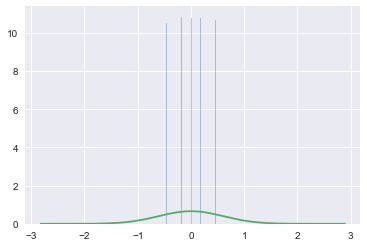

In [8]:
# Simulate the Markov process - will make this a function so can call later
def sim_markov(z_grid, pi, num_draws):
    # draw some random numbers on [0, 1]
    u = np.random.uniform(size=num_draws)

    # Do simulations
    z_discrete = np.empty(num_draws)  # this will be a vector of values 
    # we land on in the discretized grid for z
    N = z_grid.shape[0]
    oldind = int(np.ceil((N - 1) / 2)) # set initial value to median of grid
    z_discrete[0] = z_grid[oldind]  
    for i in range(1, num_draws):
        sum_p = 0
        ind = 0
        while sum_p < u[i]:
            sum_p = sum_p + pi[ind, oldind]
#             print('inds =  ', ind, oldind)
            ind += 1
        if ind > 0:
            ind -= 1
        z_discrete[i] = z_grid[ind]
        oldind = ind
                            
    return z_discrete


# Call simulation function to get simulated values
z_discrete = sim_markov(z_grid, np.transpose(pi), num_draws)
                            
                            
# Plot AR(1) and Markov approximation
sns.distplot(z_discrete, hist=True, kde=False, norm_hist=True)
sns.kdeplot(np.array(z), bw=0.5)

 ## 2.  Comparing methods
    
Working through the Adda-Cooper method was illustrative of how these approximations work.  Now let's compare across a few methods.  

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


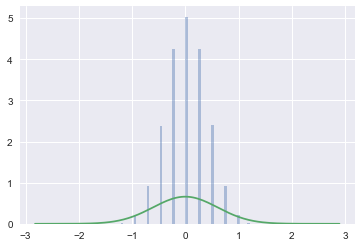

In [9]:
# import module with Markov approximation methods
import sys
sys.path.append('../Code')
import ar1_approx as ar1

# Use Rouwenhorst (1995) method
N = 11
num_sigma = 4
step = (num_sigma * sigma_z) / (N / 2)
pi_R, z_grid_R = ar1.rouwen(rho, mu, step, N)
z_discrete_R = sim_markov(z_grid_R, pi_R, num_draws)

# Plot AR(1) and Markov approximation
sns.distplot(z_discrete_R, hist=True, kde=False, norm_hist=True)
sns.kdeplot(np.array(z), bw=0.5)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


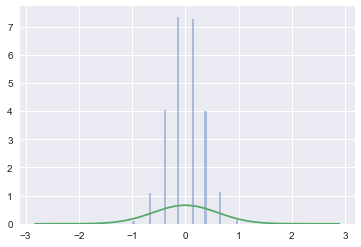

In [10]:
# Use Tauchen and Hussey (1991) method
wgt = 0.5 + rho / 4
baseSigma = wgt * sigma_eps + (1 - wgt) * sigma_z 
N_TH = 8
z_grid_TH, pi_TH = ar1.tauchenhussey(N_TH, mu, rho, sigma_eps, baseSigma)
z_discrete_TH = sim_markov(z_grid_TH[0], np.transpose(pi_TH), num_draws)

# Plot AR(1) and Markov approximation
sns.distplot(z_discrete_TH, hist=True, kde=False, norm_hist=True)
sns.kdeplot(np.array(z), bw=0.5)

One caution here, if `N>8`, the results get a bit weird with represted values for in the $z$ grid and an asymetric distribution when simulated.  I'm not sure why grid points are repeated in thh $z$ grid, but I will look into this.

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


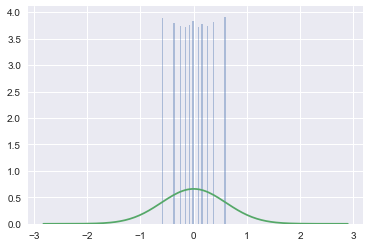

In [11]:
# Use Adda and Cooper (2003) method
z_grid_AC, pi_AC = ar1.addacooper(N, mu, rho, sigma_eps)
z_discrete_AC = sim_markov(z_grid_AC, np.transpose(pi_AC), num_draws)

# Plot AR(1) and Markov approximation
sns.distplot(z_discrete_AC, hist=True, kde=False, norm_hist=True)
sns.kdeplot(np.array(z), bw=0.5)

Three 3 plots are highly illustrative of the approaches these different methods take.  Rouwenhorst (1995) chooses and evenly spaced grid over $z$ and then fits the transition matrix over these points to produced the normal distribution found in the stationary distribution of $z$. Adda and Cooper (2003) break the the real line up into intervals with equal probability density and we see this in the density that results from the Markov process.  Tauchen and Hussey (1991) is somewhat between the other two methods in this repsect.  The grid for $z$ is not evenly spaced, but the probability density of any particular grid point varies in the stationary distribution.

Also notice how the range of values in the $z$ grid changes across methods.  The Rouwenhorst (1995) and Tauchen and Hussey (1991) methods allow you to set this range with `step` and `baseSigma`, respectively.

You can play around with `N`, $\rho$, $\sigma_{\varepsilon}$, and see how these approximations perform.  For a rigorous comparison of these approaches, please see Kopecky and Suen (2010).  They find that the Rouwenhorst (1995) method outperforms the others when $\rho$ is close to one.  You might consider the peristence and variability in the shocks to your autoregressive process when choosing the most appropriate method for your problem.

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


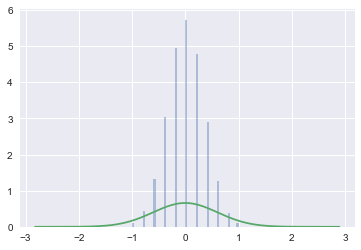

In [12]:
# Try the Tauchen method from QuantEcon
from quantecon import tauchen

qe_result = tauchen(rho, sigma_eps, 3, N)
pi_QE = qe_result.P
z_grid_QE = np.linspace(-3*sigma_z, 3*sigma_z, N) # why can't this be returned from call to function??
z_discrete_QE = sim_markov(z_grid_QE, np.transpose(pi_QE), num_draws)

# Plot AR(1) and Markov approximation
sns.distplot(z_discrete_QE, hist=True, kde=False, norm_hist=True)
sns.kdeplot(np.array(z), bw=0.5)

This looks close to Rouwenhorst since it also uses an evenly spaced grid.  I'm not sure why the `quantecon.tauchen` method only returns the transition matrix... maybe becuase it's simply a linear spaced grid over the specied range of the distribution.

## 3. References
* Adda, Jerome and Russell Cooper, *Dynamic Economics: Quantitative Methods and Applications*, MIT Press (2003).
* Kopecky, Karen and Richard Suen, "Finite State Markov-chain Approximations to Highly Persistent Processes", *Review of Economic Dynamics*, 13:3, pp. 701-714 (July 2010)
* Rouwenhorst, K Geert, "Asset Pricing Implications of Equilibrium Business Cycle Models", in *Frontiers of Business Cycle Research* (Thomas F. Cooley Ed.), Princeton University Press (1995).
* Tauchen, George and Robert Hussey, "Quadrature-Based Methods for Obtaining Approximate Solutions to Nonlinear Asset Pricing Models", *Econometrica*, 59:2, pp. 371-396, (1991).